# Extracting a weighted drive network from INRIX

INRIX stores road network links using TMCs (Traffic Monitoring Codes). This notebook provides a recipe for extracting nodes and weighted edges from INRIX data extracts for use with various network analysis tools. In our case, we'll primarily be performing our analyses with Pandana, which requires 5 pieces of network data: node_x, node_y, edge_start_node, edge_end_node, edge_weight.

In [82]:
import requests
import pandas as pd
import pandana as pdna
from geopandas import GeoDataFrame
from shapely.geometry import Point, LineString
import numpy as np
from pyproj import Proj, transform
import time
from matplotlib import pyplot as plt
from matplotlib import collections as mc
import matplotlib.cm as cm
%matplotlib inline

In [2]:
import os
import glob

## Load INRIX data

### Glob all counties

In [70]:
network_files = glob.glob('../data/*2018_06_04_mon_09_to_10_am/TMC*', recursive=True)

In [71]:
df = pd.DataFrame()
for file in network_files:
    temp = pd.read_csv(file)
    df = pd.concat([df,temp])

In [72]:
df.head()

,tmc,road,direction,intersection,state,county,zip,start_latitude,start_longitude,end_latitude,end_longitude,miles,road_order
0,105+22231,105TH AVE,EASTBOUND,CA-185/INTERNATIONAL BLVD/E 14TH ST,CA,ALAMEDA,94603,37.735439,-122.174808,37.739259,-122.166718,0.514912,1.0
1,105-22230,105TH AVE,WESTBOUND,SAN LEANDRO ST,CA,ALAMEDA,94603,37.739259,-122.166718,37.735439,-122.174808,0.514912,1.0
2,105P22223,106TH AVE,EASTBOUND,BANCROFT AVE/LINK ST,CA,ALAMEDA,94603,37.741482,-122.156987,37.741561,-122.156799,0.011632,1.0
3,105+22224,106TH AVE,EASTBOUND,MACARTHUR BLVD,CA,ALAMEDA,94603,37.741561,-122.156799,37.742957,-122.152482,0.256061,2.0
4,105+22225,106TH AVE,EASTBOUND,I-580,CA,ALAMEDA,94605,37.742957,-122.152482,37.744939,-122.148928,0.238327,3.0


We find the TMC network has a total of 21418 edges:

In [73]:
len(df['tmc'].unique())

21418

In [74]:
weight_files = glob.glob('../data/*2018_06_04_mon_09_to_10_am/*2018_06_04_mon_09_to_10_am.csv', recursive=True)

In [75]:
weights = pd.DataFrame()
for weight_file in weight_files:
    temp = pd.read_csv(weight_file)
    weights = pd.concat([weights, temp])

In [76]:
weights.tail()

,tmc_code,measurement_tstamp,speed,average_speed,reference_speed,travel_time_minutes,confidence_score,cvalue
1243,105+15662,2018-06-04 09:00:00,20.00,20.0,24.0,2.03,20.00,0.00
1244,105+16097,2018-06-04 09:00:00,20.12,20.0,21.0,2.48,24.29,41.07
1245,105P21204,2018-06-04 09:00:00,25.00,25.0,25.0,0.04,10.00,0.00
1246,105-15731,2018-06-04 09:00:00,24.18,25.0,24.0,0.63,21.79,14.29
1247,105N50183,2018-06-04 09:00:00,20.00,20.0,20.0,0.02,10.00,0.00


and also that we have speed data for 18408 edges

In [77]:
len(weights['tmc_code'].unique())

18408

## Construct the network

### Expand network file

In [85]:
exploded_nodes = pd.concat([
    df[['start_latitude', 'start_longitude']].rename(columns={'start_latitude':'latitude', 'start_longitude':'longitude'}), 
    df[['end_latitude', 'end_longitude']].rename(columns={'end_latitude':'latitude', 'end_longitude':'longitude'})],
    ignore_index=True)

### Extract nodes and edges

In [86]:
exploded_nodes.head()

,latitude,longitude
0,37.735439,-122.174808
1,37.739259,-122.166718
2,37.741482,-122.156987
3,37.741561,-122.156799
4,37.742957,-122.152482


In [87]:
nodes = exploded_nodes.drop_duplicates()
nodes.index.name = 'node_id'
nodes.reset_index(inplace=True)

In [88]:
nodes.head()

,node_id,latitude,longitude
0,0,37.735439,-122.174808
1,1,37.739259,-122.166718
2,2,37.741482,-122.156987
3,3,37.741561,-122.156799
4,4,37.742957,-122.152482


In [89]:
len(nodes['node_id'].unique())

14913

#### Project nodes to x,y

In [90]:
inProj = Proj(init='epsg:4326')
outProj = Proj(init='epsg:2768')

In [91]:
x, y = [pd.Series(x) for x in transform(inProj, outProj, nodes['longitude'].values, nodes['latitude'].values)]
nodes['x'] = x
nodes['y'] = y

/home/max/anaconda3/envs/ual-model/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/max/anaconda3/envs/ual-model/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [92]:
nodes.head()

,node_id,latitude,longitude,x,y
0,0,37.735439,-122.174808,1.852389e+06,638430.990963
1,1,37.739259,-122.166718,1.853109e+06,638842.128354
2,2,37.741482,-122.156987,1.853971e+06,639073.555769
3,3,37.741561,-122.156799,1.853988e+06,639082.028775
4,4,37.742957,-122.152482,1.854371e+06,639230.211297


### Get edge weights

In [93]:
merged = pd.merge(df, nodes, left_on=['start_latitude', 'start_longitude'], right_on=['latitude','longitude'], suffixes=('','_from'))

In [94]:
merged = pd.merge(merged, nodes, left_on=['end_latitude', 'end_longitude'], right_on=['latitude','longitude'], suffixes=('','_to'))

In [95]:
merged = merged[['tmc', 'node_id', 'node_id_to', 'miles']].rename(columns={'node_id': 'from', 'node_id_to':'to'})

In [96]:
merged.head()

,tmc,from,to,miles
0,105+22231,0,1,0.514912
1,105-06481,436,1,0.411428
2,105+08310,903,1,1.074170
3,105-13400,0,980,1.096651
4,105P10860,981,980,0.009619


In [97]:
edges = pd.merge(merged, weights, left_on='tmc', right_on='tmc_code')[['tmc', 'from', 'to', 'travel_time_minutes', 'speed', 'average_speed', 'reference_speed']]

In [98]:
edges.head()

,tmc,from,to,travel_time_minutes,speed,average_speed,reference_speed
0,105+22231,0,1,1.52,20.36,20.0,21.0
1,105-06481,436,1,1.44,17.11,17.0,20.0
2,105+08310,903,1,3.98,16.20,18.0,21.0
3,105-13400,0,980,2.25,29.29,29.0,30.0
4,105P10860,981,980,0.08,7.59,14.0,15.0


In [99]:
len(edges)

18408

## Save data

In [2]:
nodes.to_csv('/home/data/2018-07/inrix_nodes_monday_9am.csv', index=False)

NameError: name 'nodes' is not defined

In [101]:
edges.to_csv('/home/data/2018-07/inrix_edges_monday_9am.csv', index=False)

In [102]:
pd.merge(df, edges, on='tmc').to_csv('/home/data/2018-07/inrix_merged.csv', index=False)

## Load as network

In [74]:
nodes = pd.read_csv('/home/data/2018-07/inrix_nodes_monday_9am.csv', index_col='node_id')
edges = pd.read_csv('/home/data/2018-07/inrix_edges_monday_9am.csv')

In [3]:
merged = pd.merge(edges, nodes, left_on='from', right_on='node_id')

In [4]:
merged = pd.merge(merged, nodes, left_on='to', right_on='node_id', suffixes=('_from', '_to'))

In [5]:
merged.head()

,tmc,from,to,travel_time_minutes,speed,average_speed,reference_speed,node_id_from,latitude_from,longitude_from,x_from,y_from,node_id_to,latitude_to,longitude_to,x_to,y_to
0,105+22231,0,1,1.52,20.36,20.0,21.0,0,37.735439,-122.174808,1.852389e+06,638430.990963,1,37.739259,-122.166718,1.853109e+06,638842.128354
1,105-06481,436,1,1.44,17.11,17.0,20.0,436,37.744356,-122.170581,1.852779e+06,639413.771139,1,37.739259,-122.166718,1.853109e+06,638842.128354
2,105+08310,903,1,3.98,16.20,18.0,21.0,903,37.725828,-122.156899,1.853948e+06,637336.309901,1,37.739259,-122.166718,1.853109e+06,638842.128354
3,105-13400,0,980,2.25,29.29,29.0,30.0,0,37.735439,-122.174808,1.852389e+06,638430.990963,980,37.723951,-122.161488,1.853540e+06,637135.242247
4,105P10860,981,980,0.08,7.59,14.0,15.0,981,37.724017,-122.161333,1.853554e+06,637142.323436,980,37.723951,-122.161488,1.853540e+06,637135.242247


In [22]:
merged['from_point'] = [Point(xy) for xy in merged[['longitude_from', 'latitude_from']].values]

In [24]:
merged['to_point'] = [Point(xy) for xy in merged[['longitude_to', 'latitude_to']].values]

In [71]:
merged.head()

,tmc,from,to,travel_time_minutes,speed,average_speed,reference_speed,node_id_from,latitude_from,longitude_from,...,y_from,node_id_to,latitude_to,longitude_to,x_to,y_to,from_point,topoint,to_point,geometry
0,105+22231,0,1,1.52,20.36,20.0,21.0,0,37.735439,-122.174808,...,638430.990963,1,37.739259,-122.166718,1.853109e+06,638842.128354,POINT (-122.1748084 37.7354394),POINT (-122.1667176 37.7392592),POINT (-122.1667176 37.7392592),"LINESTRING (-122.1748084 37.7354394, -122.1667..."
1,105-06481,436,1,1.44,17.11,17.0,20.0,436,37.744356,-122.170581,...,639413.771139,1,37.739259,-122.166718,1.853109e+06,638842.128354,POINT (-122.170581 37.744356),POINT (-122.1667176 37.7392592),POINT (-122.1667176 37.7392592),"LINESTRING (-122.170581 37.744356, -122.166717..."
2,105+08310,903,1,3.98,16.20,18.0,21.0,903,37.725828,-122.156899,...,637336.309901,1,37.739259,-122.166718,1.853109e+06,638842.128354,POINT (-122.1568994 37.7258276),POINT (-122.1667176 37.7392592),POINT (-122.1667176 37.7392592),"LINESTRING (-122.1568994 37.7258276, -122.1667..."
3,105-13400,0,980,2.25,29.29,29.0,30.0,0,37.735439,-122.174808,...,638430.990963,980,37.723951,-122.161488,1.853540e+06,637135.242247,POINT (-122.1748084 37.7354394),POINT (-122.161488 37.723951),POINT (-122.161488 37.723951),"LINESTRING (-122.1748084 37.7354394, -122.1614..."
4,105P10860,981,980,0.08,7.59,14.0,15.0,981,37.724017,-122.161333,...,637142.323436,980,37.723951,-122.161488,1.853540e+06,637135.242247,POINT (-122.161333 37.724017),POINT (-122.161488 37.723951),POINT (-122.161488 37.723951),"LINESTRING (-122.161333 37.724017, -122.161488..."


In [67]:
merged['geometry'] = merged.apply(lambda row: LineString((row['from_point'], row['to_point'])), axis=1)

In [68]:
gdf = GeoDataFrame(merged, geometry='geometry')

In [72]:
gdf[['tmc', 'travel_time_minutes', 'speed', 'geometry']].to_file('test.shp')

In [73]:
pdna.version

'0.3.0'

In [9]:
len(pd.merge(nodes, edges, left_on='node_id', right_on='to'))

18408

In [75]:
inrix_net = pdna.Network(nodes['x'], nodes['y'], edges['from'], edges['to'], edges[['travel_time_minutes']], twoway=False)

/home/max/anaconda3/envs/ual-model/lib/python3.6/site-packages/pandana/network.py:132: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  nodes_df.as_matrix().astype('float32'),
/home/max/anaconda3/envs/ual-model/lib/python3.6/site-packages/pandana/network.py:133: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  edges.as_matrix().astype('int32'),
/home/max/anaconda3/envs/ual-model/lib/python3.6/site-packages/pandana/network.py:134: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  edges_df[edge_weights.columns].transpose()


In [76]:
def plot_net(nodes, edges, x_col=None, y_col=None, from_col=None,
             to_col=None, bbox=None,
             fig_height=6, margin=0.02,
             edge_color='#999999', edge_linewidth=1, edge_alpha=1,
             node_color='black', node_size=15, node_alpha=1,
             node_edgecolor='none', node_zorder=3, nodes_only=False):
    """
    plot urbanaccess network nodes and edges
    Parameters
    ----------
    nodes : pandas.DataFrame
    edges : pandas.DataFrame
    x_col : str, optional
        x coordinate column in nodes dataframe
    y_col : str, optional
        y coordinate column in nodes dataframe
    from_col : str, optional
        name of column to use for 'from' node id
    to_col : str, optional
        name of column to use for 'to' node id
    bbox : tuple, optional
        Bounding box formatted as a 4 element tuple:
        (lng_max, lat_min, lng_min, lat_max)
        example: (-122.304611,37.798933,-122.263412,37.822802)
        a bbox can be extracted for an area using: the CSV format
        bbox from http://boundingbox.klokantech.com/
        if None bbox will be calculated from spatial extents of data
    fig_height : int
        matplotlib figure height in inches
    margin : float
        margin around the figure
    edge_color : string
        color of the edge lines
    edge_linewidth : float
        width of the edge lines
    edge_alpha : float
        opacity of the edge lines
    node_color : string
        node color
    node_size : int
        node size
    node_alpha : float
        node opacity
    node_edgecolor : string
        the color of the node border
    node_zorder : int
        zorder to plot nodes, edges are zorder 2. A node_zorder 1 will plot
        nodes under the edges, 3 will plot nodes on top
    nodes_only : bool
        if true only the nodes will plot
    Returns
    -------
    fig, ax
    """

    start_time = time.time()

    # set default x and y cols if none specified
    if 'x' in nodes.columns or 'y' in nodes.columns or x_col is \
            None or y_col is None:
        x_col = 'x'
        y_col = 'y'

    # set default from_col and to_col cols if none specified
    if ('from_int' in edges.columns or 'to_int' in edges.columns) and \
            (from_col is None or to_col is None):
        from_col = 'from_int'
        to_col = 'to_int'

    # set default from_col and to_col cols if none specified
    if ('node_id_from' in edges.columns or 'node_id_to' in edges.columns) and \
            (from_col is None or to_col is None):
        from_col = 'node_id_from'
        to_col = 'node_id_to'

    # if edge df is subset make sure nodes are also subset to match
    from_ids = nodes[nodes.index.isin(list(edges[from_col]))]
    to_id = nodes[nodes.index.isin(list(edges[to_col]))]
    node_ids = pd.concat([from_ids, to_id], ignore_index=False)
    nodes = nodes[nodes.index.isin(list(node_ids.index))]

    node_Xs = nodes[x_col].tolist()
    node_Ys = nodes[y_col].tolist()

    if nodes_only is False:
        if 'from_lon' not in edges.columns \
                or 'to_lon' not in edges.columns \
                or 'from_lat' not in edges.columns \
                or 'from_lon' not in edges.columns:

            edges = _prep_edges(edges=edges, nodes=nodes,
                                from_col=from_col, to_col=to_col,
                                x_col=x_col, y_col=y_col)

    if bbox is None:
        y_max = max(node_Ys)
        y_min = min(node_Ys)
        x_max = max(node_Xs)
        x_min = min(node_Xs)
    else:
        x_min, y_min, x_max, y_max = bbox

    if y_max - y_min <= 0 or x_max - x_min <= 0:
        raise ValueError(('difference between min and max x and or y resulted '
                          'in a negative value or 0'))
    bbox_aspect_ratio = (y_max - y_min) / (x_max - x_min)

    fig, ax = plt.subplots(figsize=(fig_height / bbox_aspect_ratio,
                                    fig_height))

    if nodes_only is False:
        # TODO: optimize for speed by calculating only for edges that are
        # within the the bbox + buffer distance to speed up
        lines = []
        for index, node in edges.iterrows():
            x1, y1, x2, y2 = node['from_lon'], node['from_lat'], \
                             node['to_lon'], node['to_lat']
            line = [(x1, y1), (x2, y2)]
            lines.append(line)

        lc = mc.LineCollection(lines, colors=edge_color,
                               linewidths=edge_linewidth,
                               alpha=edge_alpha, zorder=2)
        ax.add_collection(lc)

    ax.scatter(node_Xs, node_Ys, s=node_size, c=node_color,
               alpha=node_alpha, edgecolor=node_edgecolor,
               zorder=node_zorder)

    # set fig extent
    margin_ns = (y_min - y_max) * margin
    margin_ew = (x_min - x_max) * margin
    ax.set_ylim((y_min - margin_ns, y_max + margin_ns))
    ax.set_xlim((x_min - margin_ew, x_max + margin_ew))

    # configure axis
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.get_yaxis().get_major_formatter().set_useOffset(False)
    ax.axis('off')

#     log('Figure created. Took {:,.2f} seconds'.format(
#         time.time() - start_time))

    plt.show()

    return fig, ax

In [77]:
def _prep_edges(edges, nodes, from_col, to_col,
                x_col, y_col):
    """
    Prepare edges to display edges as lines on the plot
    Parameters
    ----------
    nodes : pandas.DataFrame
    edges : pandas.DataFrame
    from_col : string
        name of column to use for 'from' node id
    to_col : string
        name of column to use for 'to' node id
    x_col : string
        name of column to use for 'x' node coordinates
    y_col : string
        name of column to use for 'y' node coordinates
    Returns
    -------
    edges_wline : pandas.DataFrame
        the edge dataframe with from and to x y coordinates and
        ids to build lines
    """

    if x_col not in nodes.columns or y_col not in nodes.columns:
        raise ValueError(
            '{} or {} columns were not found in nodes columns'.format(x_col,
                                                                      y_col))

    if from_col not in edges.columns or to_col not in edges.columns:
        raise ValueError(
            '{} or {} columns were not found in edges columns'.format(from_col,
                                                                      to_col))

    edges_wline = edges.merge(nodes[[x_col, y_col]], left_on=from_col,
                              right_index=True)
    edges_wline.rename(columns={x_col: 'from_lon', y_col: 'from_lat'},
                       inplace=True)
    edges_wline = edges_wline.merge(nodes[[x_col, y_col]], left_on=to_col,
                                    right_index=True)
    edges_wline.rename(columns={x_col: 'to_lon', y_col: 'to_lat'},
                       inplace=True)

    return edges_wline

In [92]:
def col_colors(df, col, num_bins=5, bin_type='quantile', cmap='spectral',
               start=0.1, stop=0.9):
    """
    Get a list of colors by binning a continuous variable column
    into quantiles
    Parameters
    ----------
    df : pandas.DataFrame
    col : string
        the name of the column in the dataframe with the continuous variable
    num_bins : int
        how many quantiles
    cmap : string
        name of a colormap
    start : float
        where to start in the colorspace
    stop : float
        where to end in the colorspace
    Returns
    -------
    colors : list
    """
    col = df[df[col].notnull()][col]
    bins_used, categories = _recursive_category_gen(col, num_bins, bin_type=bin_type)

    if not bins_used == num_bins:
        log('Too many bins requested, using max bins possible. '
            'To avoid duplicate edges, ' + str(bins_used) + ' bins used.')

    color_list = [cm.get_cmap(cmap)(x) for x in np.linspace(start,
                                                            stop,
                                                            bins_used)]
    cleaned_categories = [int(cat) for cat in categories]
    colors = [color_list[cat] for cat in cleaned_categories]
    return colors

In [95]:
def _recursive_category_gen(col, num_bins, bin_type='quantile'):
    """
    Generate number of bins recursively
    Parameters
    ----------
    col : string
        the name of the column in the dataframe with the continuous variable
    num_bins : int
        how many quantiles
    Returns
    -------
    num_bins : int
    categories : list
    """

    bin_labels = range(num_bins)

    # base case catch
    if num_bins == 0:
        raise ValueError('Unable to perform qcut to 0 bins.')

    # we assume the num_bins count will work
    try:
        if bin_type == 'quantile':
            categories = pd.qcut(x=col, q=num_bins, labels=bin_labels)
        elif bin_type == 'equal_interval':
            categories = pd.cut(x=col, bins=num_bins, labels=bin_labels)
        return num_bins, categories

    # if it does not, then we need to go down 1 number of bins
    except ValueError:
        new_bin_count = num_bins - 1
        return _recursive_category_gen(col, new_bin_count)

In [96]:
edgecolor = col_colors(df=edges, col='speed', cmap='YlOrRd', num_bins=5, bin_type='equal_interval')

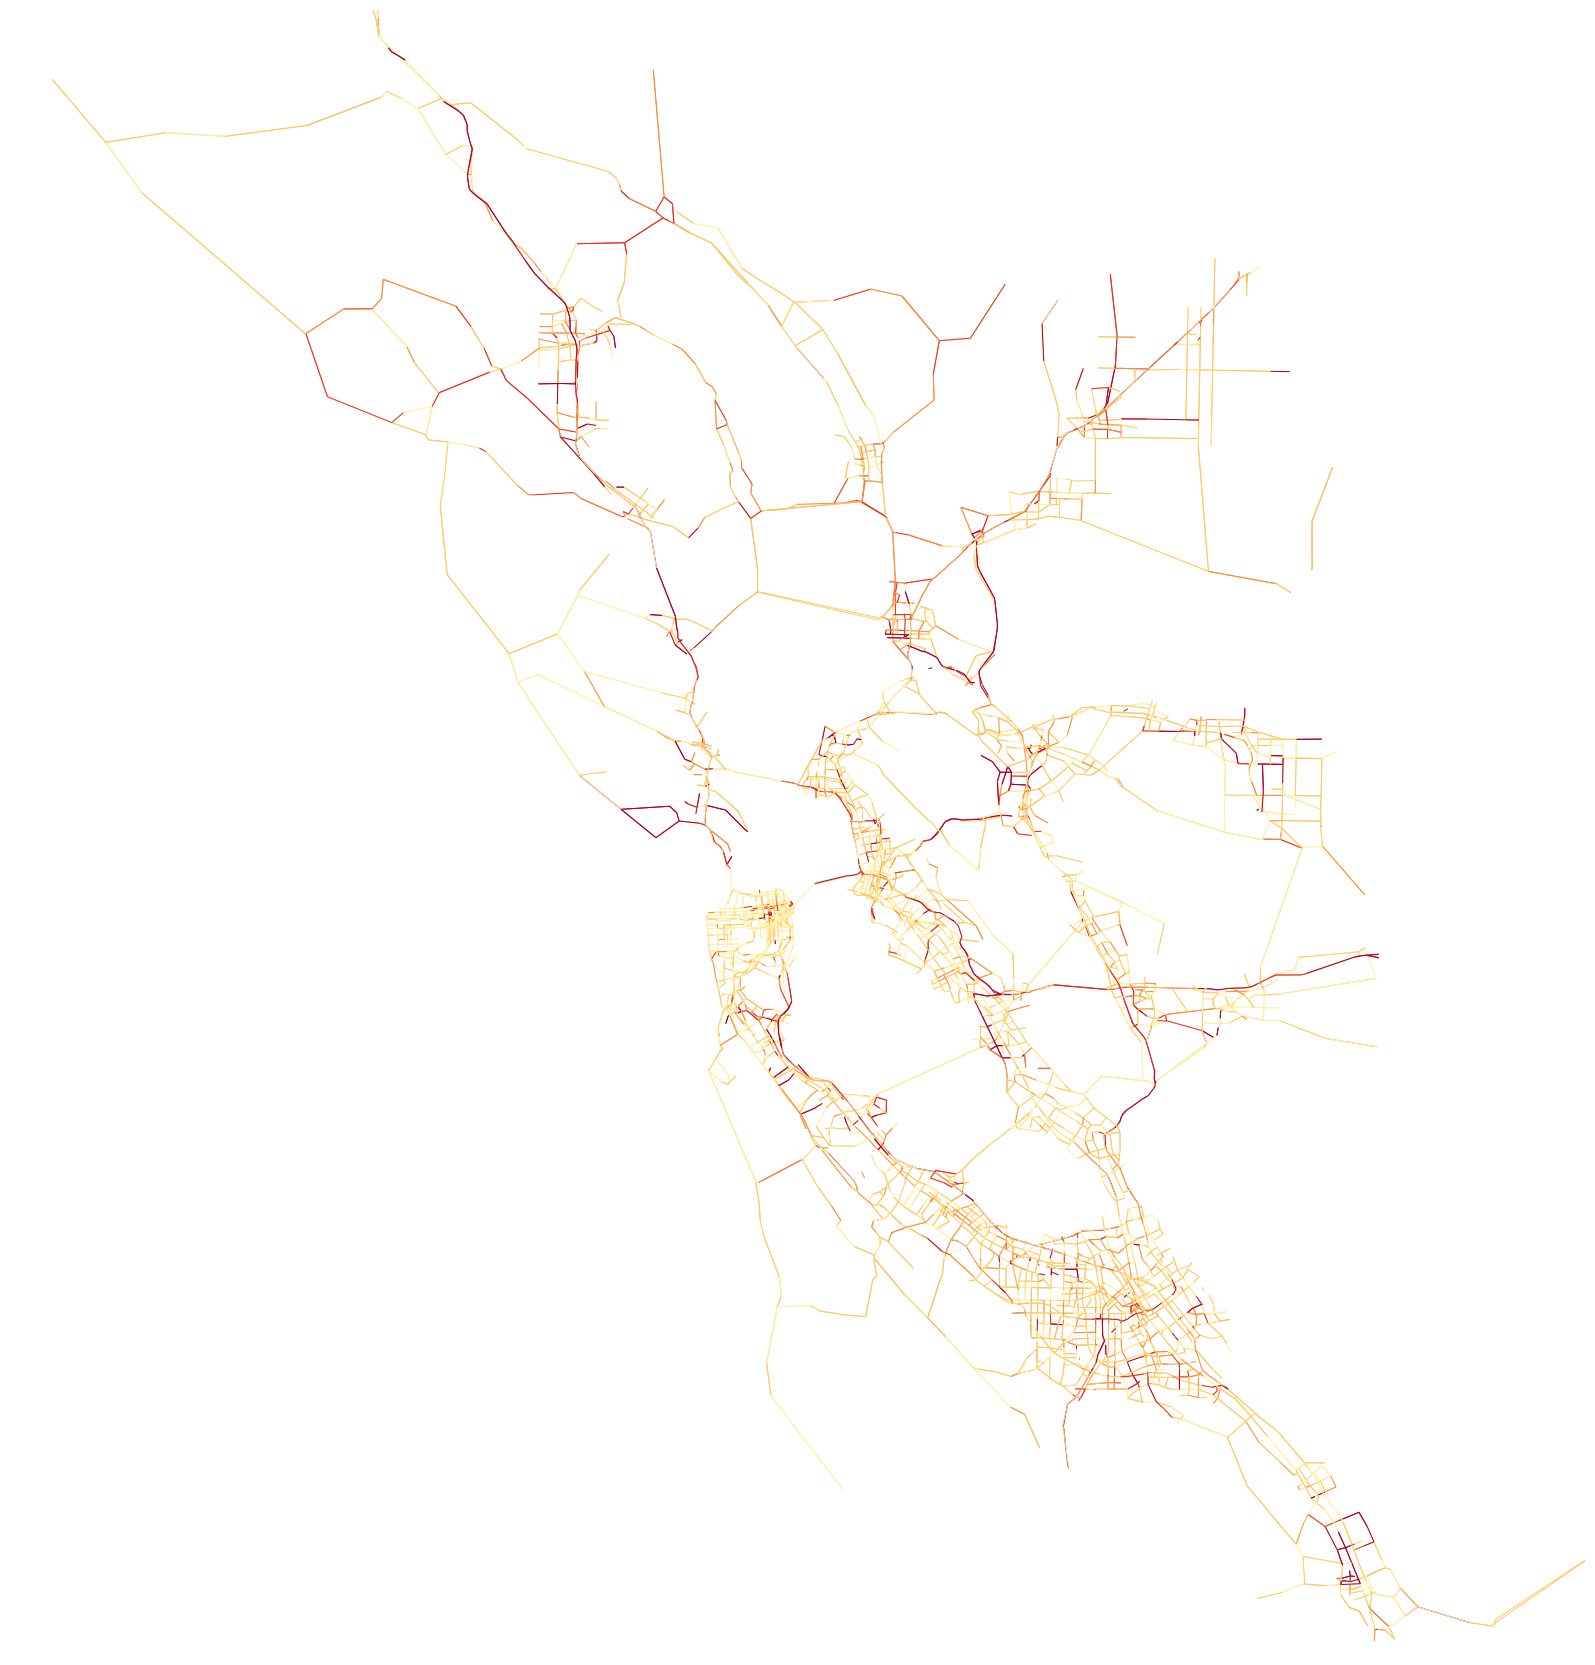

(<Figure size 1977.72x2160 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb3c09105f8>)

In [99]:
plot_net(nodes, edges, 'longitude', 'latitude', 'from', 'to', fig_height=30, margin=0.02,
                 edge_color=edgecolor, edge_linewidth=1, edge_alpha=1,
                 node_color='black', node_size=0, node_alpha=1, node_edgecolor='none', node_zorder=3)

In [4]:
len(edges['to'].unique())

13008

In [5]:
len(nodes)

14913